Synaptic Activity File for Golgi_Cell_2020

In [1]:
# 04 - Synaptic activity, Parallel fibers, ascending axons, mossy fibers and inibition.
import matplotlib.pyplot as plt
from neuron import h
from Golgi2020_morpho_1 import Golgi_morpho_1
import multiprocessing
import random as rnd
import numpy as np

In [2]:
seed = 123456
rnd.seed(seed)
h.use_mcell_ran4(1)
h.mcell_ran4_init(seed)

0.0

In [3]:
#Instantiation of the cell template
subtype = "morpho_1"
cell = Golgi_morpho_1(subtype)
#fixed time step only
Fixed_step = h.CVode()
Fixed_step.active(0)


5394 lines read


False

In [4]:
#this code discover the number of cores available in a CPU and activate the multisplit to use them all.
cpu = multiprocessing.cpu_count() // 2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(cpu,1)
p.multisplit(1)
#simulation length
stimdata = dict()
stimdata['timeglobal'] =  5000
#Number of spikes, interval, starting moment and presence of noise
synapsesdata = dict()

4


In [6]:
#parallel fiber
synapsesdata['syninterval'] = 10
synapsesdata['synnumber'] = 5
synapsesdata['synstart'] = 1000
synapsesdata['synnoise'] = 0

#mossy fiber
synapsesdata['syninterval_mf'] = 10
synapsesdata['synnumber_mf'] = 5
synapsesdata['synstart_mf'] = 1000
synapsesdata['synnoise_mf'] = 0

#ascending axon
synapsesdata['syninterval_aa'] = 10
synapsesdata['synnumber_aa'] = 5
synapsesdata['synstart_aa'] = 1000
synapsesdata['synnoise_aa'] = 0

#Delay factor to activate two different type of synapses in two different moments.
synapsesdata['synpfdelay'] = 0
synapsesdata['synmfdelay'] = 0

synapsesdata['synaadelay'] = 0
synapsesdata['synindelay'] = 0

#number of synapses (max used in the paper)
pf_syn = 89 #89
mf_syn = 0 #20

aa_syn = 0 #20
inib_syn = 0 #20

cell.createsyn(pf_syn, mf_syn, aa_syn)

In [8]:
#PF syn
spk_stim_pf = []
totalstim = int(stimdata['timeglobal']/  synapsesdata['synstart'])

for j in range(int(totalstim)):
    spk_stim = h.NetStim()
    spk_stim.interval=synapsesdata['syninterval']
    spk_stim.number=synapsesdata['synnumber']
    spk_stim.noise=synapsesdata['synnoise']
    spk_stim.start=(synapsesdata['synstart'] * (totalstim - j)) + synapsesdata['synpfdelay']
    
    spk_stim_pf.append(spk_stim)
    spk_nc_pfsyn = []
    j = j-1

print('len pf', len(cell.L_PF))

for m in range(int(totalstim)):	
    spk_nc_pfsyn.append([h.NetCon(spk_stim_pf[m],PF.input,0,0.1,1) for PF in cell.L_PF])

len pf 89


In [9]:
#MF syn
spk_stim_mf = []
totalstim1 = int(stimdata['timeglobal']/  synapsesdata['synstart_mf'])

for j in range(int(totalstim1)):
    spk_stim_2 = h.NetStim()
    spk_stim_2.interval=synapsesdata['syninterval_mf']
    spk_stim_2.number=synapsesdata['synnumber_mf']
    spk_stim_2.noise=synapsesdata['synnoise_mf']
    spk_stim_2.start=(synapsesdata['synstart_mf'] * (totalstim1 - j))   + synapsesdata['synmfdelay'] 
    
    spk_stim_mf.append(spk_stim_2)
    spk_nc_mfsyn = []
    spk_nc_mfsyn_B = []
    j = j-1

print('len mf', len(cell.L_MF))

for v in range(int(totalstim1)):	
    spk_nc_mfsyn.append([h.NetCon(spk_stim_mf[v],MF.input,0,0.1,1) for MF in cell.L_MF])
    spk_nc_mfsyn_B.append([h.NetCon(spk_stim_mf[v],MF_nmda_B.input,0,0.1,1) for MF_nmda_B in cell.L_MF_NMDA_B])

len mf 0


In [10]:
#AA syn
spk_stim_aa = []
totalstim_aa = int(stimdata['timeglobal']/  synapsesdata['synstart_aa'])

for j in range(int(totalstim_aa)):
    spk_stim_3 = h.NetStim()
    spk_stim_3.interval=synapsesdata['syninterval_aa']
    spk_stim_3.number=synapsesdata['synnumber_aa']
    spk_stim_3.noise=synapsesdata['synnoise_aa']
    spk_stim_3.start=(synapsesdata['synstart_aa'] * (totalstim_aa - j))   + synapsesdata['synaadelay'] 
    
    spk_stim_aa.append(spk_stim_3)
    spk_nc_aasyn = []
    spk_nc_aasyn_B = []
    j = j-1

print('len aa', len(cell.L_AA))

for z in range(int(totalstim_aa)):	
    spk_nc_aasyn.append([h.NetCon(spk_stim_aa[z],AA.input,0,0.1,1) for AA in cell.L_AA])
    spk_nc_aasyn_B.append([h.NetCon(spk_stim_aa[z],MF_nmda_B.input,0,0.1,1) for MF_nmda_B in cell.L_AA_NMDA_B])

len aa 0


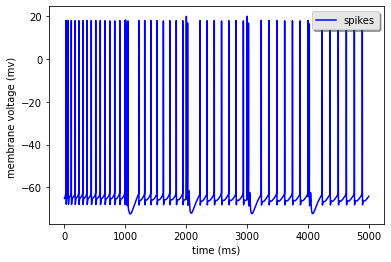

In [11]:
#Basic properties of the simulation. dt, temperature, sim duration and initial voltage
h.dt = 0.025
h.celsius = 32
h.tstop = stimdata['timeglobal']
h.v_init = -65

#Initialization 
def initialize():
    h.finitialize()
    h.run()
    
initialize()

#Save a time voltage trace which will be different based on the number and type of active synapses
def save_trace(time_vec, vm_vec, pf_n, aa_n, mf_n, inib_n):
    fig, ax = plt.subplots()
    ax.plot(time_vec, vm_vec, 'b', label='spikes')

    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv) ")
    
save_trace(np.array(cell.time_vector), np.array(cell.vm), pf_syn, aa_syn, mf_syn, inib_syn)